In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_columns = 99

In [2]:
os.chdir('..')  # change to root directory

In [3]:
# Load data
import pickle
from firenet.util import add_uncertainty_features
with open('./data/d_data.pkl', 'rb') as infile:
    d_data = pickle.load(infile)
    
d_data = add_uncertainty_features(d_data)
d_data.keys()

dict_keys(['fullbay', 'fullbayerr', 'shortbay', 'shortbayerr', 'redshift', 'observed', 'observederr', 'obserr_to_short', 'obs_to_short'])

# Single train/test split

In [4]:
from firenet.ml import RegUncPredictor

pred = RegUncPredictor(d_data)
pred.preprocess()
pred.train_regressor()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.8961        0.6486     +  0.0738
      2        0.5484        0.3819     +  0.0712
      3        0.3848        0.3157     +  0.0733
      4        0.3383        0.2893     +  0.0867
      5        0.3156        0.2717     +  0.0725
      6        0.2973        0.2579     +  0.0692
      7        0.2819        0.2459     +  0.0690
      8        0.2685        0.2365     +  0.0824
      9        0.2572        0.2291     +  0.0727
     10        0.2479        0.2231     +  0.0754
     11        0.2403        0.2183     +  0.0756
     12        0.2338        0.2143     +  0.0725
     13        0.2285        0.2109     +  0.0739
     14        0.2238        0.2083     +  0.0745
     15        0.2198        0.2061     +  0.0724
     16        0.2163        0.2043     +  0.0980
     17        0.2131        0.2026     +  0.0867
     18        0.2103        0.2013     +  0.0721


In [5]:
pred.train_uncertainty()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      310.8786       95.9195     +  0.0854
      2     -199.4971     -575.8018     +  0.0751
      3    -1050.5906    -1435.4730     +  0.0705
      4    -1889.4351    -2053.0776     +  0.0714
      5    -2430.6969    -2390.3005     +  0.0708
      6    -2728.6080    -2563.1772     +  0.0735
      7    -2889.1526    -2654.0943     +  0.0700
      8    -2980.1104    -2706.0879     +  0.0689
      9    -3037.0599    -2740.0419     +  0.0704
     10    -3076.6635    -2764.1990     +  0.0706
     11    -3105.9200    -2781.9251     +  0.0721
     12    -3128.1500    -2795.2132     +  0.0668
     13    -3145.3900    -2805.1928     +  0.0729
     14    -3158.8989    -2812.5523     +  0.0689
     15    -3169.8464    -2818.1734     +  0.0709
     16    -3179.0253    -2822.7123     +  0.0935
     17    -3186.8078    -2826.6352     +  0.0794
     18    -3193.6094    -2830.0125     +  0.0702


In [6]:
pred.reg.test()

PACS_70      0.219829
PACS_100     0.192468
PACS_160     0.175038
SPIRE_250    0.187781
SPIRE_350    0.201360
SPIRE_500    0.214558
Name: rmse, dtype: float64

In [7]:
pred.unc.test()

PACS_70      1.108272
PACS_100     1.146611
PACS_160     1.242209
SPIRE_250    1.125294
SPIRE_350    1.042729
SPIRE_500    0.994705
Name: mean_chisq, dtype: float64

In [8]:
y_t, y_p, y_perr = pred.get_target_set()

In [9]:
# Storing and loading models
from firenet.ml import ModelStore

ModelStore().store(pred, name='nnet')  # Save to './models/nnet.pkl' by default
pred = ModelStore().load(d_data, name='nnet')  # Load "nnet" model

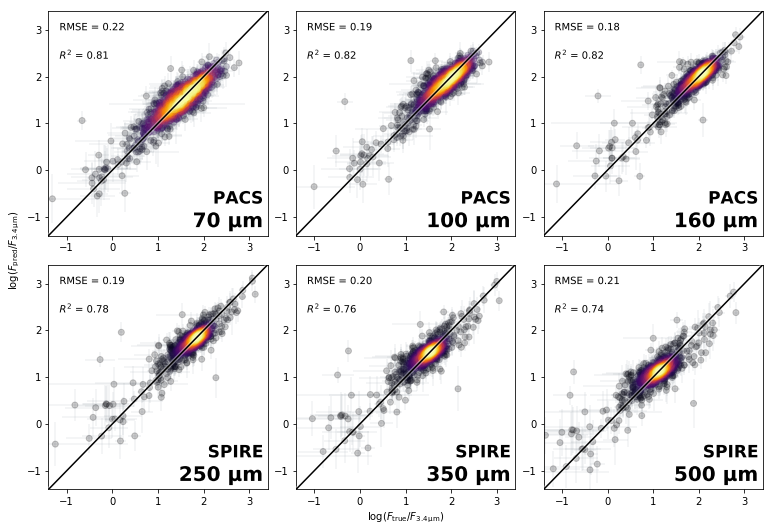

In [10]:
from firenet.plotting.truevspred import TrueVSPredPlotter

firbands = d_data['fullbay'].columns[-6:]
idx = y_t.index
y_terr = d_data['fullbayerr'].loc[idx, firbands].divide(d_data['fullbay'].loc[idx] * np.log(10), axis=0)

tvpplot = TrueVSPredPlotter(figsize=(12.8, 8.8))
tvpplot.create_panels(nrows=1)
panel = tvpplot.get_panel(0)
panel.stylized_plot(y_t, y_p, y_terr=y_terr, y_perr=y_perr, 
                    style='firflux')

# Full set predictor
Using a 4-fold train/test split, training 4 predictors. Each galaxy is used as a test sample once.

In [11]:
from firenet.ml.fullsetpredictor import FullSetPredictor
fspred = FullSetPredictor(d_data)

In [12]:
fspred.prepare_splits(shuffle_state=123)

In [13]:
fspred.train()

Start training model 1/4...
Start training model 2/4...
Start training model 3/4...
Start training model 4/4...


In [14]:
# Storing and loading models
from firenet.ml.modelstore import ModelStore

ModelStore().store(fspred, name='fsnnet')  # Save to './models/fsnnet.pkl' by default
fspred = ModelStore().load(d_data, name='fsnnet')  # Load "fsnnet" model

In [15]:
y_t, y_p, y_perr = fspred.get_combined_test()

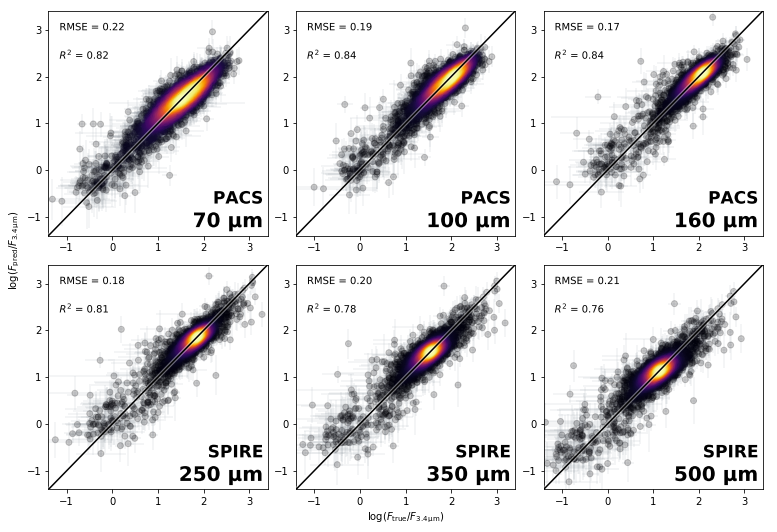

In [16]:
# See paper Fig. 3
from firenet.plotting.truevspred import TrueVSPredPlotter

firbands = d_data['fullbay'].columns[-6:]
idx = y_t.index
y_terr = d_data['fullbayerr'].loc[idx, firbands].divide(d_data['fullbay'].loc[idx] * np.log(10), axis=0)

tvpplot = TrueVSPredPlotter(figsize=(12.8, 8.8))
tvpplot.create_panels(nrows=1)
panel = tvpplot.get_panel(0)
panel.stylized_plot(y_t, y_p, y_terr=y_terr, y_perr=y_perr, 
                    style='firflux')

# Use all (DustPedia + H-ATLAS) data into single model
This model can then be used for other data sets (see notebook `04_predicting.ipynb`)

In [17]:
# Use all data for training and testing (no longer unbiased test set)
idx_tot = d_data['fullbay'].index.values.copy()
np.random.seed(123)
np.random.shuffle(idx_tot)
pred = RegUncPredictor(d_data)
pred.preprocess(idx_train=idx_tot, idx_test=idx_tot)
pred.train_regressor()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.7966        0.5251     +  0.0940
      2        0.4379        0.3339     +  0.1005
      3        0.3475        0.2975     +  0.0920
      4        0.3182        0.2802     +  0.0933
      5        0.2995        0.2669     +  0.0901
      6        0.2847        0.2570     +  0.0941
      7        0.2722        0.2492     +  0.0893
      8        0.2623        0.2431     +  0.0898
      9        0.2545        0.2387     +  0.0919
     10        0.2481        0.2349     +  0.0927
     11        0.2429        0.2319     +  0.0904
     12        0.2382        0.2294     +  0.0947
     13        0.2342        0.2269     +  0.0937
     14        0.2306        0.2244     +  0.0927
     15        0.2272        0.2213     +  0.0904
     16        0.2240        0.2187     +  0.1026
     17        0.2211        0.2159     +  0.0941
     18        0.2183        0.2132     +  0.0937


In [18]:
pred.train_uncertainty()

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      182.7964     -232.4729     +  0.1116
      2     -807.1544    -1421.1117     +  0.0974
      3    -1959.7688    -2228.6783     +  0.0956
      4    -2597.6032    -2573.8929     +  0.0905
      5    -2876.6481    -2715.0055     +  0.0942
      6    -3001.8670    -2779.7341     +  0.0927
      7    -3066.7832    -2816.5406     +  0.1017
      8    -3106.6200    -2840.8391     +  0.0930
      9    -3133.6409    -2856.8127     +  0.0912
     10    -3153.1653    -2868.3453     +  0.0978
     11    -3168.1559    -2877.4107     +  0.0880
     12    -3180.1817    -2884.6609     +  0.0941
     13    -3190.0155    -2890.6335     +  0.0984
     14    -3198.4756    -2895.5766     +  0.0921
     15    -3205.5608    -2899.7802     +  0.0910
     16    -3211.8570    -2903.4679     +  0.0918
     17    -3217.2852    -2906.6087     +  0.0900
     18    -3222.1177    -2909.2936     +  0.0986


In [19]:
pred.reg.test(tset='train')

PACS_70      0.205186
PACS_100     0.175639
PACS_160     0.148837
SPIRE_250    0.158219
SPIRE_350    0.174002
SPIRE_500    0.188328
Name: rmse, dtype: float64

In [20]:
ModelStore().store(fspred, name='nnet_alldata')